# DBSCAN

In [1]:
import numpy as np
import pandas as pd
import time

### Create synthetic dataset

In [2]:
n_rows = 10000
n_cols = 500
n_clusters_data = 10
cluster_std = 1.0
dtype='float32'
from sklearn.datasets import make_blobs
data, _ = make_blobs(
        n_samples=n_rows, n_features=n_cols, centers=n_clusters_data, cluster_std=cluster_std, random_state=0
    )  # make_blobs creates a random dataset of isotropic gaussian blobs.

data = data.astype(dtype)

### Convert dataset to Spark DataFrame

In [3]:
pd_data = pd.DataFrame({"features": list(data)})
df = spark.createDataFrame(pd_data)

## Spark RAPIDS ML DBSCAN (GPU)

In [4]:
from spark_rapids_ml.dbscan import DBSCAN
gpu_dbscan = DBSCAN(eps=50.0, min_samples=3).setFeaturesCol("features")

Estimator can be persisted and reloaded.

In [5]:
estimator_path = "/tmp/dbscan-estimator"

In [6]:
gpu_dbscan.write().overwrite().save(estimator_path)
gpu_dbscan_loaded = DBSCAN.load(estimator_path)

### Fit

In [7]:
start_time = time.time()
gpu_model = gpu_dbscan_loaded.fit(df)
print(f"Fit took: {time.time() - start_time} sec")

24/04/02 18:48:37 WARN TaskSetManager: Stage 2 contains a task of very large size (1734 KiB). The maximum recommended task size is 1000 KiB.


Fit took: 1.487236499786377 sec


In [8]:
gpu_dbscan_loaded.getEps()

50.0

### Transform

In [9]:
model_path = "/tmp/dbscan-model"

In [10]:
gpu_model.write().overwrite().save(model_path)

In [11]:
gpu_model_loaded = gpu_model.read().load(model_path)

In [12]:
transformed_df = gpu_model_loaded.setPredictionCol("transformed").transform(df)

24/04/02 18:48:39 WARN TaskSetManager: Stage 7 contains a task of very large size (1734 KiB). The maximum recommended task size is 1000 KiB.
24/04/02 18:48:39 WARN TaskSetManager: Stage 8 contains a task of very large size (1734 KiB). The maximum recommended task size is 1000 KiB.
2024-04-02 18:48:43,538 - spark_rapids_ml.dbscan.DBSCANModel - INFO - Loading data into python worker memory
2024-04-02 18:48:43,579 - spark_rapids_ml.dbscan.DBSCANModel - INFO - Initializing cuml context
2024-04-02 18:48:45,756 - spark_rapids_ml.dbscan.DBSCANModel - INFO - Invoking cuml fit
2024-04-02 18:48:45,980 - spark_rapids_ml.dbscan.DBSCANModel - INFO - Cuml fit complete


In [13]:
transformed_df.printSchema()

root
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- transformed: long (nullable = true)



In [14]:
transformed_df.count()

10000

In [15]:
transformed_df.show(10)

24/04/02 18:48:47 WARN TaskSetManager: Stage 20 contains a task of very large size (1734 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----------+
|            features|transformed|
+--------------------+-----------+
|[-4.5395985, -2.8...|          8|
|[1.5987521, -11.0...|          9|
|[8.420858, -0.463...|          7|
|[1.8443346, 3.242...|          6|
|[1.2457993, 5.358...|          6|
|[2.4375074, -1.37...|          2|
|[-2.8402522, 7.79...|          5|
|[-1.5907966, 6.31...|          4|
|[-1.0504782, 5.61...|          4|
|[7.0262156, -5.74...|          1|
+--------------------+-----------+
only showing top 10 rows



## Compare DBSCAN vs KMeans

### Create Ring Shape Dataset

In [16]:
def generate_random_points_in_ring(center, inner_radius, outer_radius, num_points):
    # Generate random angles
    angles = np.random.uniform(0, 2 * np.pi, num_points)

    # Generate random radii within the ring
    radii = np.sqrt(np.random.uniform(inner_radius**2, outer_radius**2, num_points))

    # Convert polar coordinates to Cartesian coordinates
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)

    # Create array of points
    points = np.column_stack((x, y))

    return points

data_inner = generate_random_points_in_ring((0,0), 1, 2, 500)
data_outer = generate_random_points_in_ring((0,0), 4, 5, 500)
data = np.concatenate((data_inner, data_outer), axis=0)
np.random.shuffle(data)

pd_data = pd.DataFrame({"features": list(data)})
df = spark.createDataFrame(pd_data)

### Run DBSCAN

In [17]:
dbscan = DBSCAN(eps=1.0, min_samples=5).setFeaturesCol("features")
dbscan_model = dbscan.fit(df)
dbscan_transformed = dbscan_model.transform(df)

dbscan_pd = dbscan_transformed.toPandas()
dbscan_np = dbscan_pd.to_numpy()

2024-04-02 18:48:47,906 - spark_rapids_ml.dbscan.DBSCANModel - INFO - Loading data into python worker memory
2024-04-02 18:48:47,908 - spark_rapids_ml.dbscan.DBSCANModel - INFO - Initializing cuml context
2024-04-02 18:48:49,082 - spark_rapids_ml.dbscan.DBSCANModel - INFO - Invoking cuml fit
2024-04-02 18:48:49,086 - spark_rapids_ml.dbscan.DBSCANModel - INFO - Cuml fit complete


### Run KMeans

In [18]:
from spark_rapids_ml.clustering import KMeans
kmeans =  KMeans(k=2).setFeaturesCol("features")
kmeans_model = kmeans.fit(df)
kmeans_transformed = kmeans_model.transform(df)

kmeans_pd = kmeans_transformed.toPandas()
kmeans_np = kmeans_pd.to_numpy()

2024-04-02 18:48:49,900 - spark_rapids_ml.clustering.KMeans - INFO - Stage-level scheduling in spark-rapids-ml requires spark standalone or local-cluster mode
2024-04-02 18:48:49,902 - spark_rapids_ml.clustering.KMeans - INFO - Training spark-rapids-ml with 1 worker(s) ...
2024-04-02 18:48:50,009 - spark_rapids_ml.clustering.KMeans - INFO - Loading data into python worker memory
2024-04-02 18:48:50,011 - spark_rapids_ml.clustering.KMeans - INFO - Initializing cuml context
2024-04-02 18:48:51,092 - spark_rapids_ml.clustering.KMeans - INFO - Invoking cuml fit
2000
2024-04-02 18:48:51,388 - spark_rapids_ml.clustering.KMeans - INFO - iterations: 10, inertia: 0.0
2024-04-02 18:48:51,390 - spark_rapids_ml.clustering.KMeans - INFO - Cuml fit complete
2024-04-02 18:48:52,579 - spark_rapids_ml.clustering.KMeans - INFO - Finished training


### Compare Clustering Result

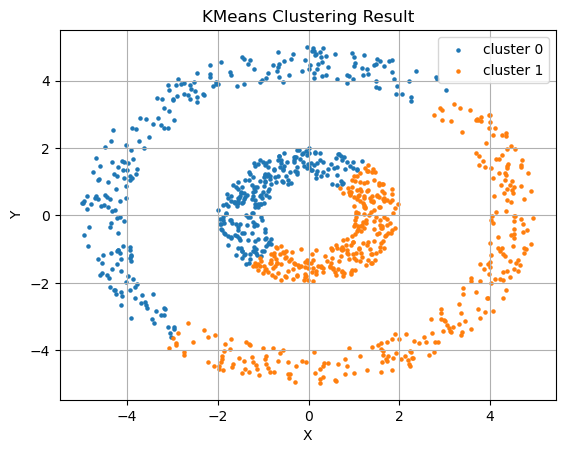

In [19]:
import matplotlib.pyplot as plt

cluster0 = []
cluster1 = []
for p in kmeans_np:
    if (p[1] == 0):
        cluster0.append(p[0])
    else:
        cluster1.append(p[0])

cluster0 = np.array(cluster0)
cluster1 = np.array(cluster1)
        
plt.scatter(cluster0[:, 0], cluster0[:, 1], s=5, label="cluster 0")
plt.scatter(cluster1[:, 0], cluster1[:, 1], s=5, label="cluster 1")
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title('KMeans Clustering Result')
plt.legend()
plt.grid(True)
plt.show()

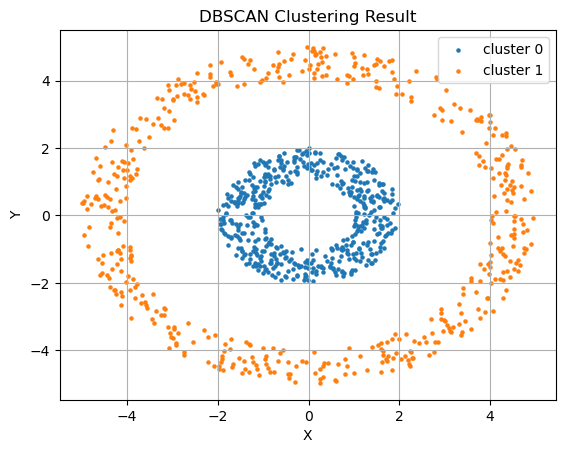

In [20]:
cluster0 = []
cluster1 = []
for p in dbscan_np:
    if (p[1] == 0):
        cluster0.append(p[0])
    else:
        cluster1.append(p[0])

cluster0 = np.array(cluster0)
cluster1 = np.array(cluster1)
        
plt.scatter(cluster0[:, 0], cluster0[:, 1], s=5, label="cluster 0")
plt.scatter(cluster1[:, 0], cluster1[:, 1], s=5, label="cluster 1")
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering Result')
plt.legend()
plt.grid(True)
plt.show()